In [4]:
%cd ..

/Users/huytrq/Workspace/unicas/AIA&ML/Wrist-Fracture-Detection


In [5]:
## Import system library
import os
import glob

## Import Image Processing library
import cv2
import skimage
import numpy as np
from skimage import exposure
from skimage.color import rgb2gray
from skimage.filters import unsharp_mask
from skimage.filters import threshold_otsu
from skimage.morphology import disk, closing, dilation, erosion, opening
import matplotlib.pyplot as plt
%matplotlib inline

from utils.preprocess import sliding_window

## Import machine learning library
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from utils.lbp import LBP
from utils.vis import draw_bboxes
from utils.dataset import load_yolo_labels
from utils.bboxes import iou, calculate_boxA_percentage
from utils.intensity_transforms import histogram_matching, calculate_mean_histogram

In [6]:
## Defind dataset folders

# root_path = '/content/drive/Shareddrives/Wrist_fracture_detectiom/ML/Dataset'
root_path = 'MLDataset/crop_data'

img_train_folder = 'train'
img_test_folder = 'test'
label_folder = 'labels'
image_folder = 'images'

In [14]:
mean_histogram = np.load('mean_hist.npy')

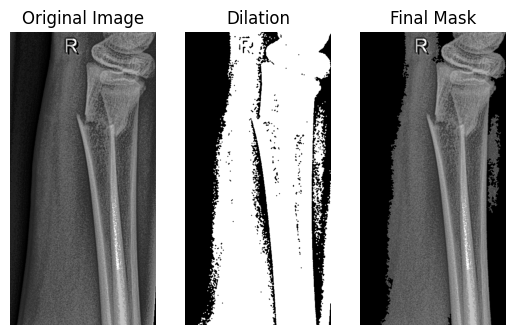

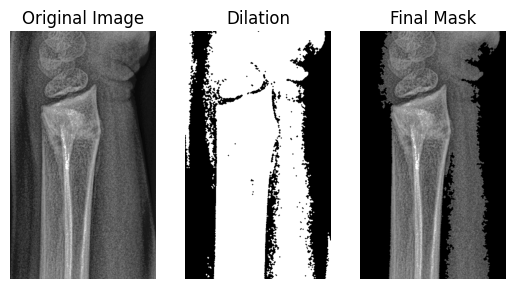

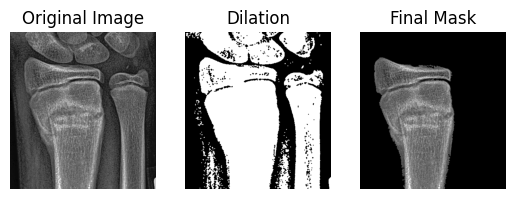

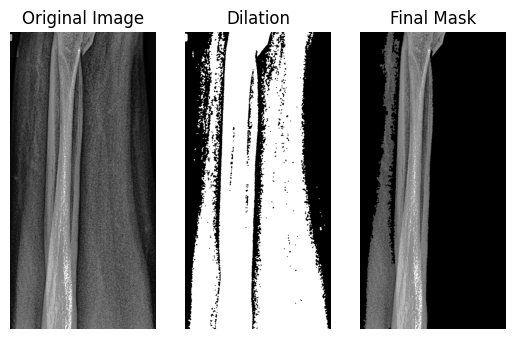

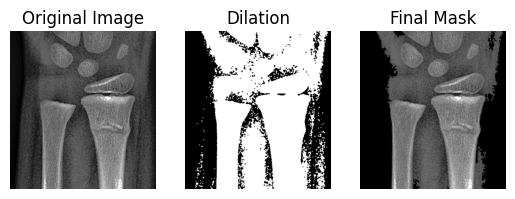

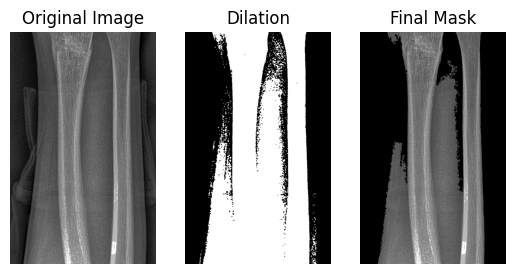

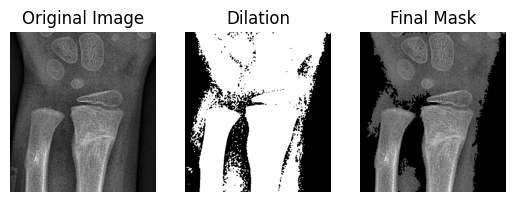

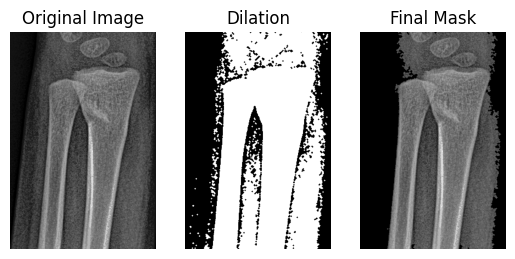

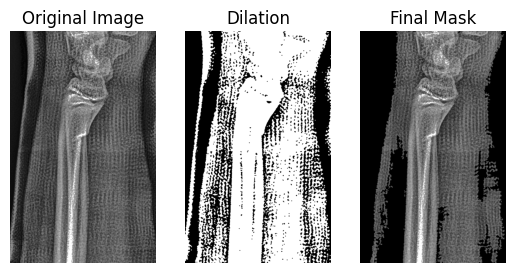

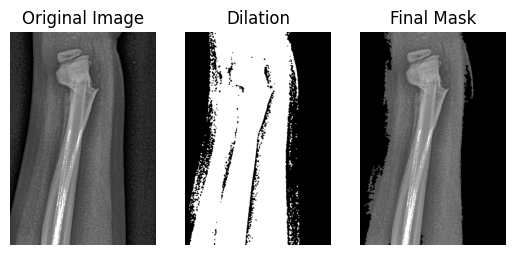

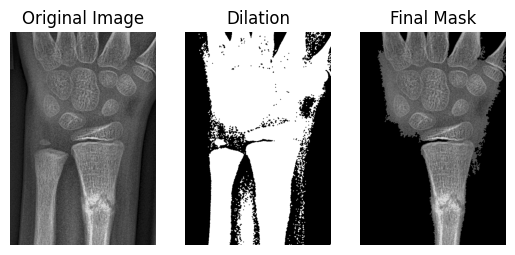

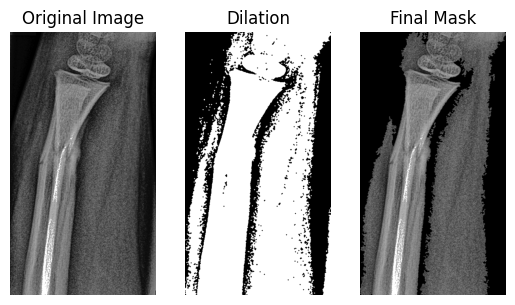

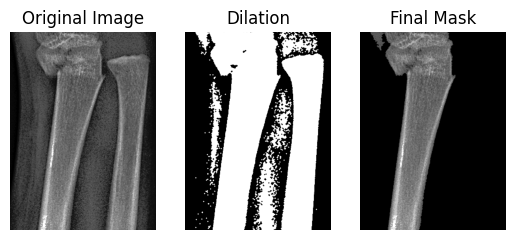

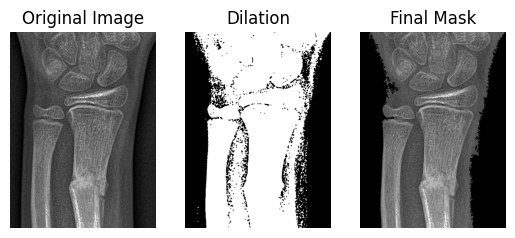

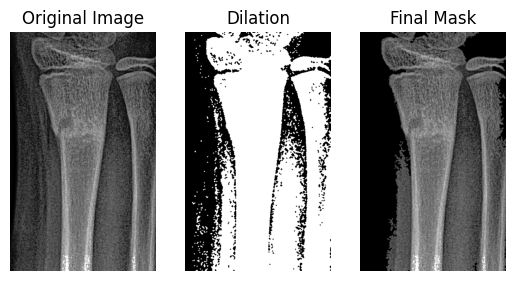

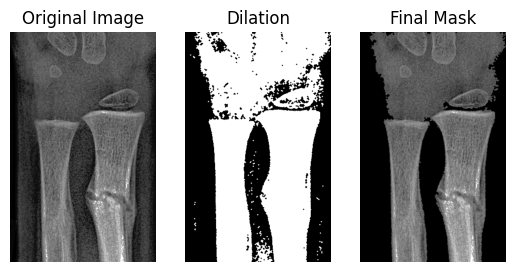

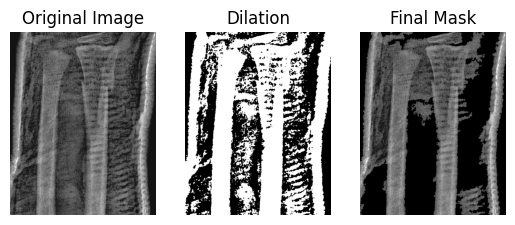

KeyboardInterrupt: 

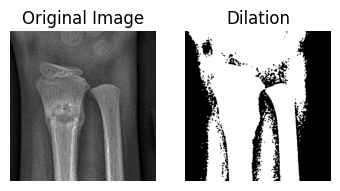

In [40]:
intensity_crop = 1
outputbitdepth = 8 
unsharp = True
dilate_num = 1

for j, image_path in enumerate(glob.glob(os.path.join(root_path, image_folder, img_train_folder, 'fracture/*.png'))):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    org_image = image.copy()
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    elif isinstance(image, np.ndarray):
        if image.ndim == 3:
            image = rgb2gray(image)
    else:
        raise ValueError("Image must be a file path or numpy array.")
    
    if unsharp:
        image = ((unsharp_mask(image, radius=2, amount=1))*255).clip(0, 255).astype(np.uint8) # unsharp mask to enhance edges

    ## Histogram equalization
    image = exposure.rescale_intensity(image, in_range=(np.percentile(image, intensity_crop), np.percentile(image, (100-intensity_crop))))
    image = exposure.equalize_adapthist(image)

    
    ## Normalize image
    image = cv2.normalize(image, dst=None, alpha=0, beta=int((pow(2, outputbitdepth))-1), norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    
    # Apply histogram matching (assuming this function is defined elsewhere)
    if mean_histogram is not None:  
        image = histogram_matching(image, mean_histogram)
    
    # Apply Otsu's thresholding
    thresh = threshold_otsu(image)
    binary_mask = image > thresh
    
    # Convert boolean mask to 8-bit integer
    binary_mask = binary_mask.astype(np.uint8) * 255  # Convert boolean to uint8
    
    # Apply multiple dilations
    selem = disk(1)
    dilated_mask = binary_mask
    for _ in range(dilate_num):
        dilated_mask = dilation(dilated_mask, selem)
    
    # Apply closing to the dilated mask
    closed_mask = closing(dilated_mask, selem)
    
    contours, _ = cv2.findContours(closed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(org_image, contours, -1, (255, 0, 0), 2)  # Draw all contours in blue with thickness 2

        # Find the largest contour based on area
    max_area = 0
    largest_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            largest_contour = contour
    
    # Create a mask for the largest contour
    if largest_contour is not None:
        mask = np.zeros_like(binary_mask)
        cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)
    
        # Apply the mask to the original image
        final_image = cv2.bitwise_and(image, image, mask=mask)
    
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title('Dilation')
        plt.imshow(closed_mask, cmap='gray')
        plt.axis('off')
        
        
        plt.subplot(1, 3, 3)
        plt.title('Final Mask')
        plt.imshow(final_image, cmap='gray')
        plt.axis('off')
        plt.show()
    

    

    
    # # Apply the mask to the original image using a bitwise AND operation
    # final_image = cv2.bitwise_and(image, image, mask=np.uint8(closed_mask * 255))



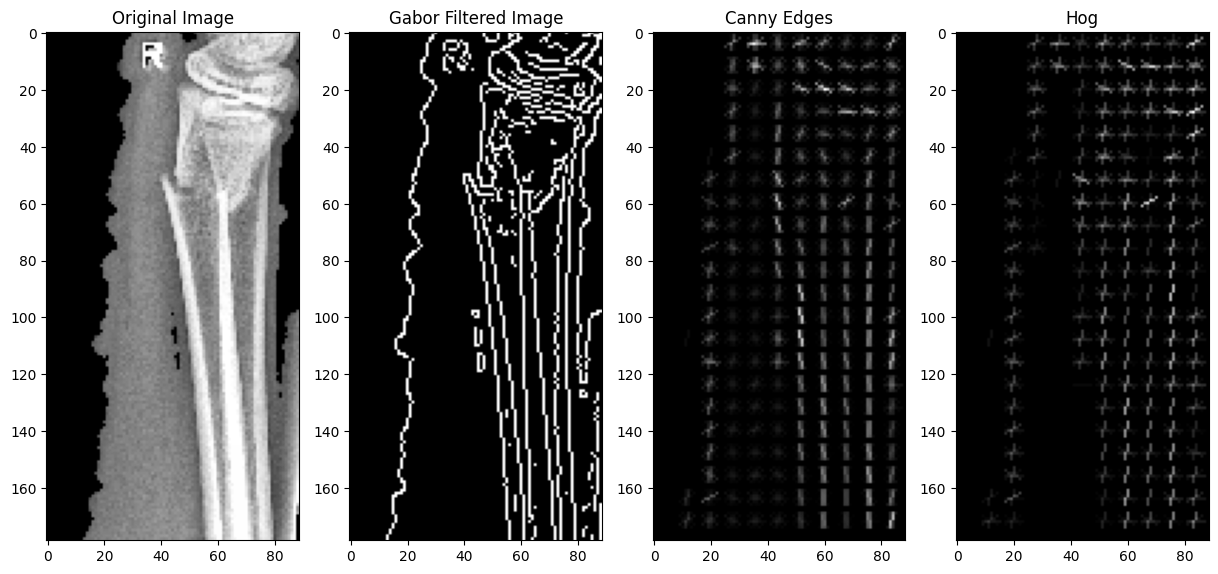

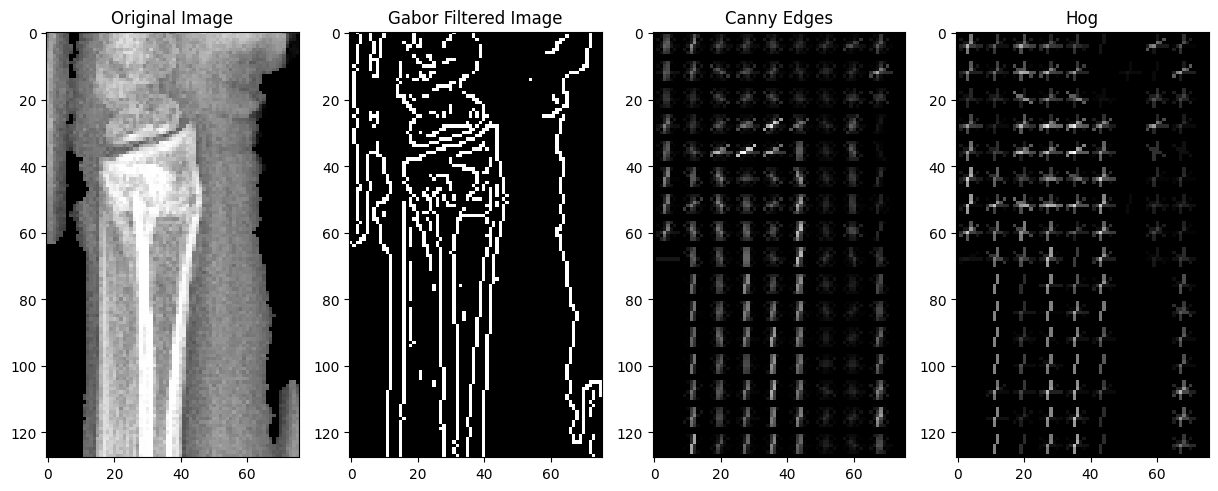

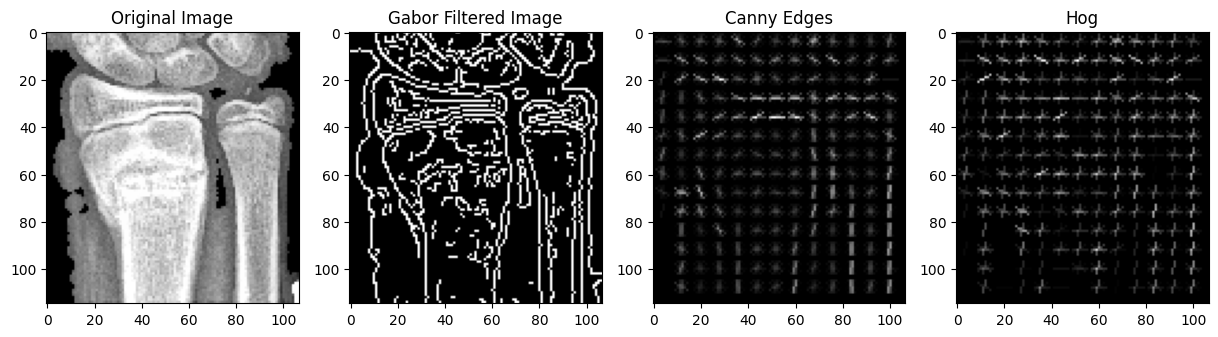

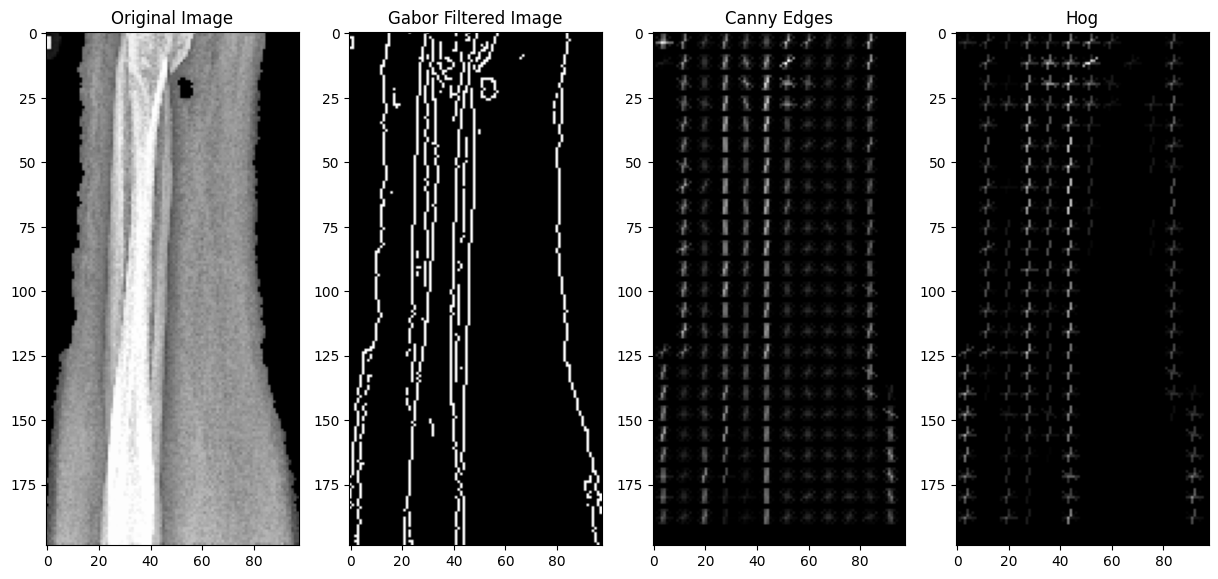

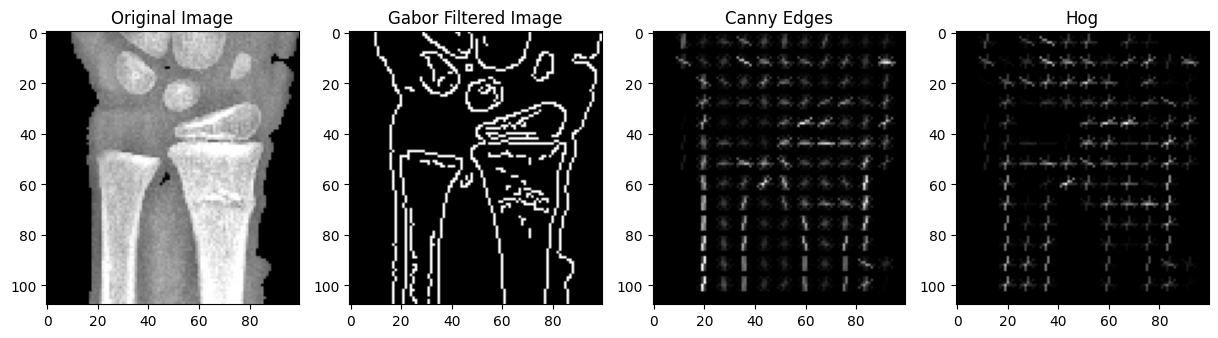

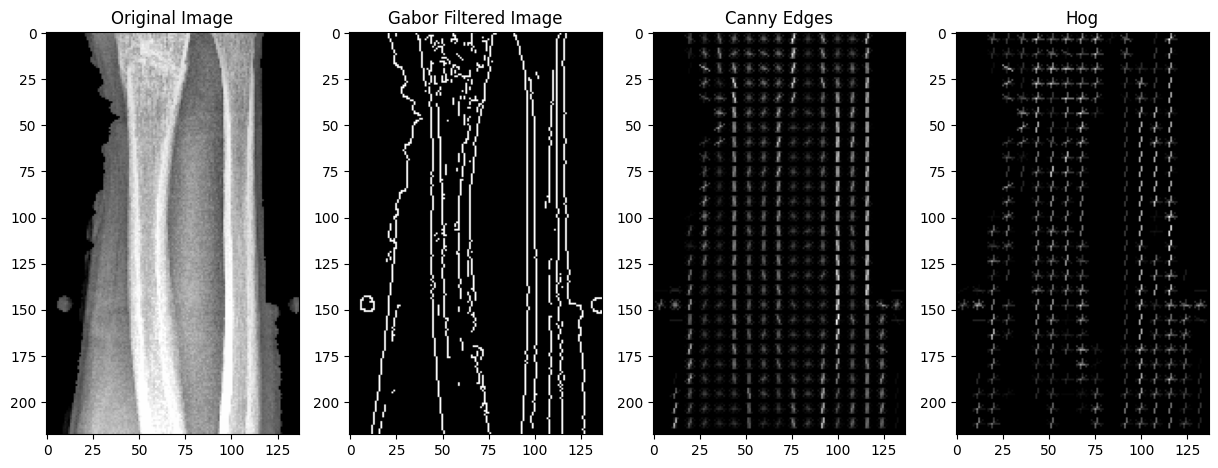

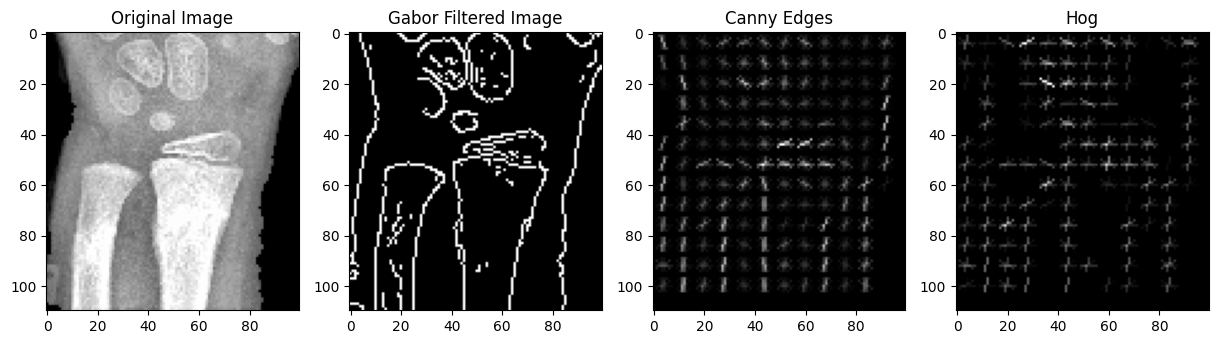

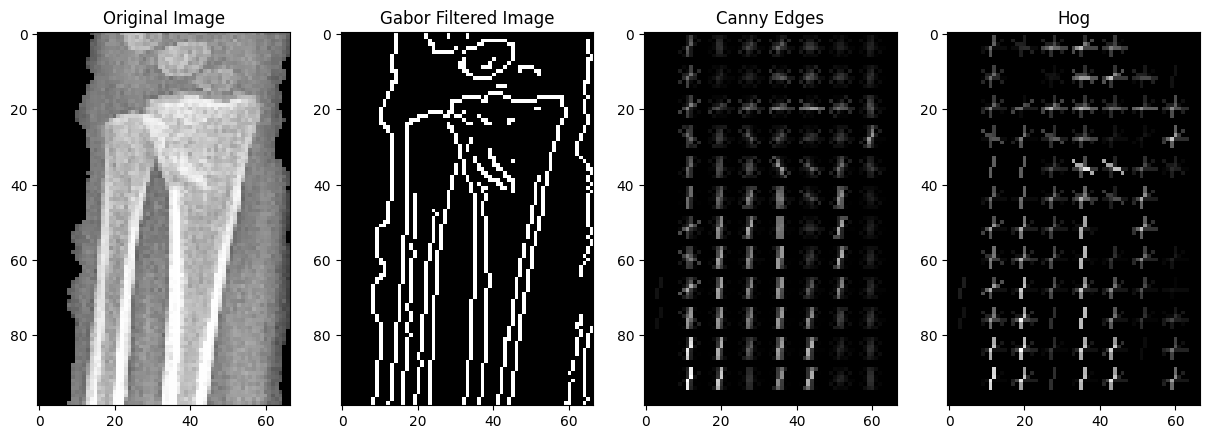

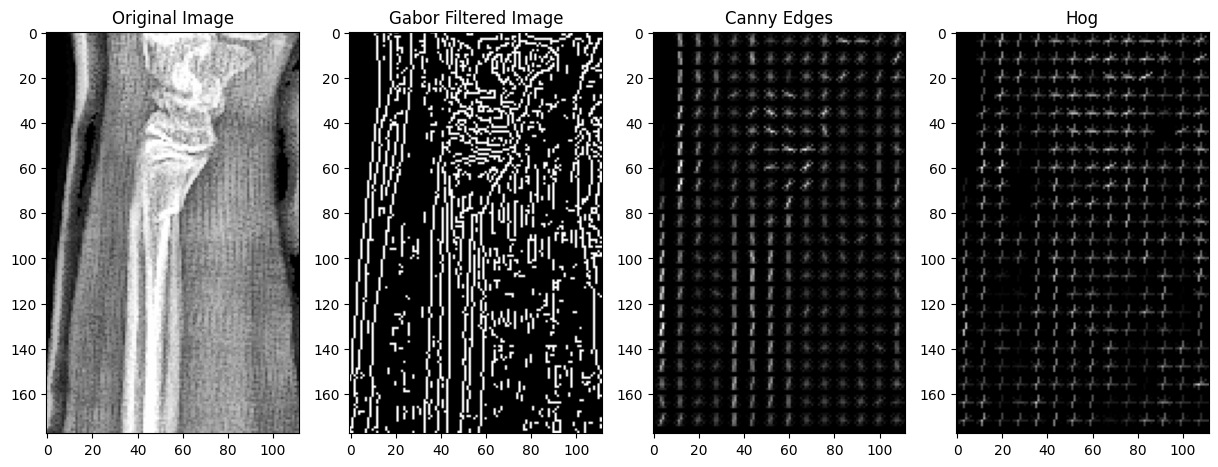

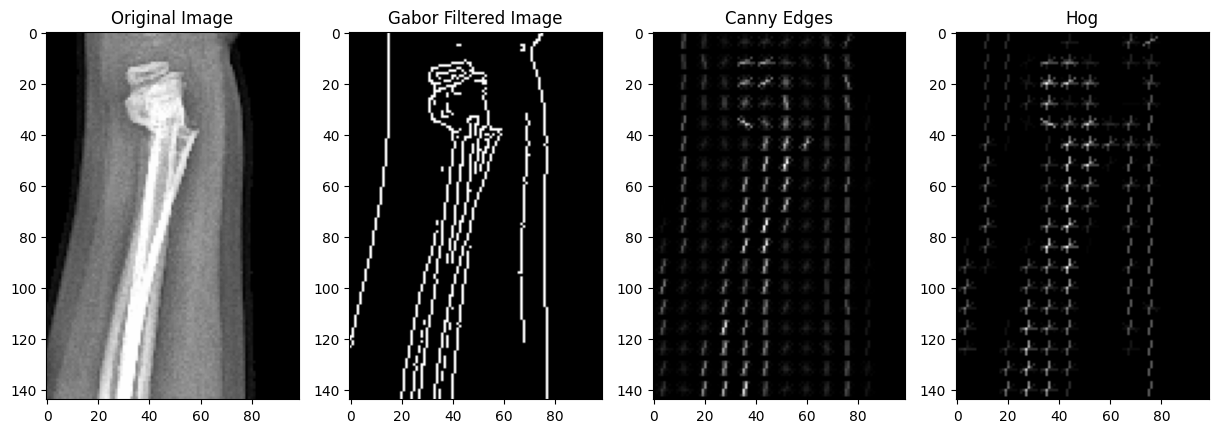

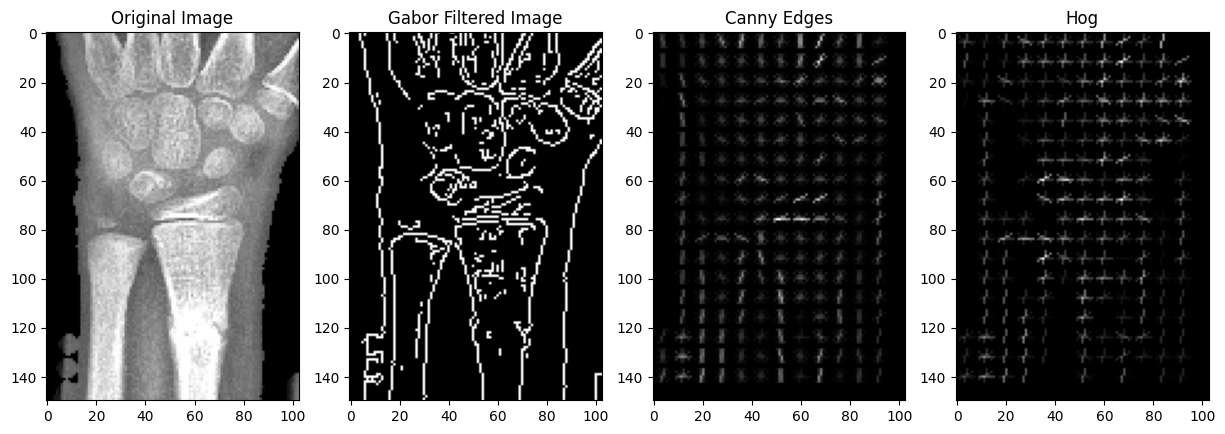

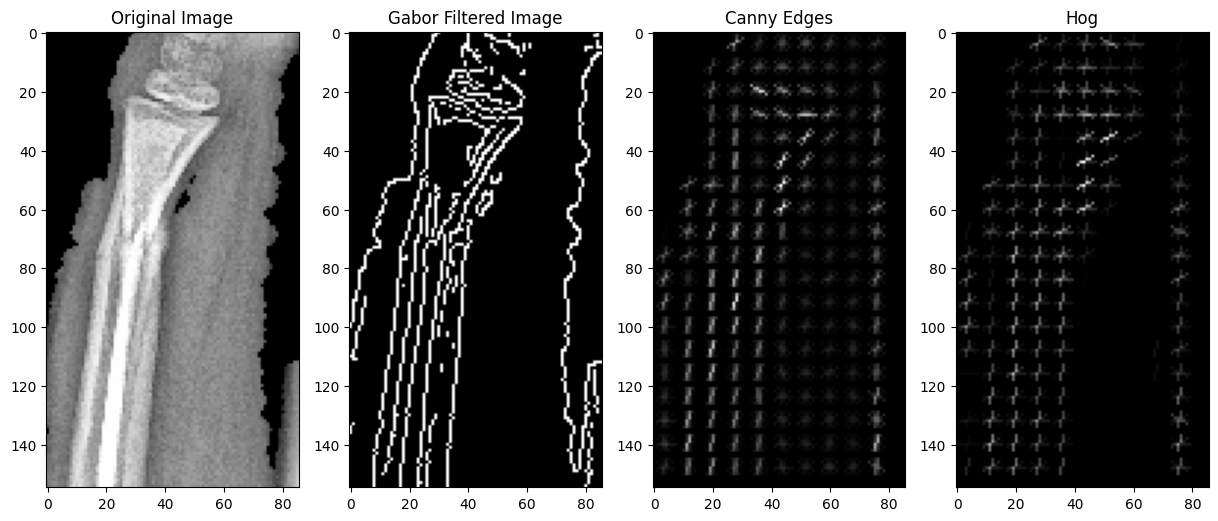

In [107]:

from skimage.feature import hog
from skimage.filters import gabor, gabor_kernel
from scipy.ndimage import convolve

mode = 'train'
class_name = 'fracture'

# Function to apply a Gabor kernel to an image
def apply_gabor_kernel(image, kernel):
    filtered = np.sqrt(convolve(image, np.real(kernel))**2 + convolve(image, np.imag(kernel))**2)
    # filtered = convolve(image, np.real(kernel)) + convolve(image, np.imag(kernel))
    return filtered

for idx, image in enumerate(glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))):
    # Load the image
    image = preprocess(image)
    image = skimage.measure.block_reduce(image, (4,4), np.max)

    frequency = 0.6
    sigma_x = 1
    sigma_y = 1
    n_stds = 3
    offset = 0
    mode = 'reflect'
    cval = 0
    
    # Parameters for Gabor kernels
    frequencies = [0.8]
    thetas = [np.pi/4, 3*np.pi/4]

    filtered_image = 0
    for i, frequency in enumerate(frequencies):
        for j, theta in enumerate(thetas):
            kernel = gabor_kernel(frequency, theta=theta)
            filtered_image = apply_gabor_kernel(image, kernel)
            
    filtered_image = cv2.normalize(filtered_image.astype(np.uint8), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Use the Canny edge detector
    edges = cv2.Canny(image, 150, 200)
    
    
    fd, hog_image = hog(edges, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)
    
    fd, hog_image1 = hog(image, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)

    # Display the results
    plt.figure(figsize=(15, 10))

    plt.subplot(1, 4, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')

    plt.subplot(1, 4, 2)
    plt.title('Gabor Filtered Image')
    plt.imshow(edges, cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title('Canny Edges')
    plt.imshow(hog_image1, cmap='gray')
    
    plt.subplot(1, 4, 4)
    plt.title('Hog')
    plt.imshow(hog_image, cmap='gray')

    plt.show()
    if idx > 10:
        break

In [ ]:
from skimage.feature import hog
from utils.dataset import resize_keep_aspect_ratio

for idx, image in enumerate(glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))):
    # Load the image
    image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    image = skimage.measure.block_reduce(image, (3,3), np.max)
    
    image = preprocess(image)
    image1 = cv2.resize(image, (64, 64))
    # image = resize_keep_aspect_ratio(image, (64, 64))
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)

    # Rescale the HOG image for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Display the results
    plt.figure(figsize=(30, 15))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title('HOG Visualization')
    plt.imshow(hog_image, cmap='gray')

    plt.show()

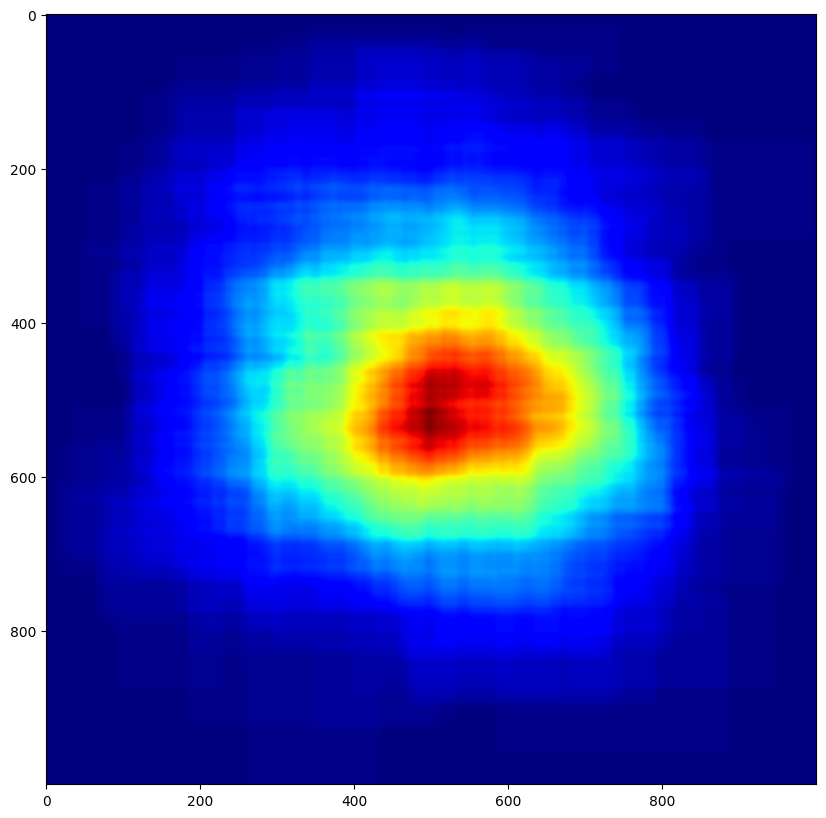

In [69]:
def generate_heatmap_from_folder(image_folder, label_folder, blur=False):
    image_files = glob(os.path.join(image_folder, '*.png'))  # Adjust the extension as needed
    heatmap = None
    image_shape = (1000, 1000)
    
    for image_path in image_files:
        label_path = os.path.join(label_folder, os.path.basename(image_path).replace('.png', '.txt'))
        if not os.path.exists(label_path):
            continue
        
        image = cv2.imread(image_path)
        if heatmap is None:
            # image_shape = image.shape
            heatmap = np.zeros(image_shape[:2], dtype=np.float32)
        
        labels = load_yolo_labels(label_path, image_shape)
        if labels:
            heatmap += create_heatmap(labels, image_shape)
    
    if heatmap is not None and np.any(heatmap):  # Ensure heatmap is not empty
        if blur:
            heatmap = cv2.GaussianBlur(heatmap, (15, 15), 0)
        
        heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    return heatmap


# Example usage
image_folder = '../MLDataset/crop_data/images/train/fracture/'
label_folder = '../MLDataset/crop_data/labels/train/fracture/'

heatmap = generate_heatmap_from_folder(image_folder, label_folder, blur=True)

plt.figure(figsize=(10, 10))
plt.imshow(heatmap, cmap='jet')
np.save('crop_heatmap.npy', heatmap)

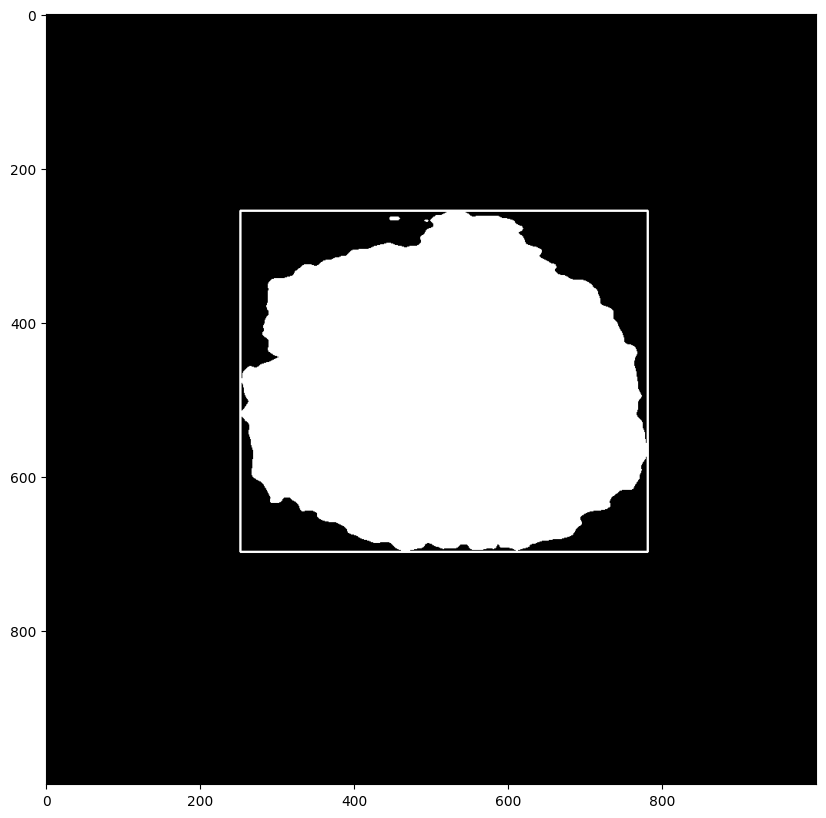

In [68]:
# Thresholding the image to segment the heatmap
_, segmented_image = cv2.threshold(heatmap, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bounding_boxes = [cv2.boundingRect(contour) for contour in contours][-1]
x, y, w, h = bounding_boxes
cv2.rectangle(segmented_image, (x, y), (x + w, y + h), (255, 255, 255), 2)
plt.figure(figsize=(10, 10))
plt.imshow(segmented_image, cmap='gray')
plt.show()
